<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2020 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Integrantes** 
* **S**ebastian Godinez
* **A**lexander  Ruz
* **D**aniel Toro

**Temas**  

* Arquitectura Básica de Redes Neuronales. Redes *Feed-Forward*
* Entrenamiento de Redes Neuronales. 
* Redes Convolucionales. 

**Formalidades**  
* Equipos de trabajo de: 3 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Formato de entrega: envı́o de link Github y link de video Youtube o plataforma a convenir, todo esto vía Aula. 

<hr style="height:2px;border:none"/>

### **Propuesta**
* Se debe preparar una presentación de **15 a 20 minutos** donde se explique el cómo se va a realizar/resolver el taller, la metodología o propuesta de las componentes a experimentar y explorar. Más detalles en el Syllabus.
* Fecha de encuentro Zoom: 8 de Mayo en horario de clases.
* Fecha de entrega de vídeo: Opcional para quienes presentaron y obligatorio para quienes no, a lo más 2 días después del encuentro.
* Modalidad de Presentación (Zoom): En el primer bloque, se formarán 3 grupos para que alcancen a recibir feedback todos los equipos. En el segundo bloque, algunos equipos seleccionados presentarán a todo el curso. 

**Aún si la idea es aprender colaborativamente, valoraremos mucho la diversidad de ideas, por lo que las propuesta debiesen conservar su orientación inicial, excepto por el feedback que les entreguemos**

### **Defensa**
* Se debe preparar una presentación de **15 a 20 minutos** con los resultados obtenidos y conclusiones de la experiencia. 
* Se debe entregar el código, de preferencia en un (breve) Jupyter/IPython notebook, de modo que **permita reproducir los resultados** presentados. Si se entrega el código fuente se deben proveer instrucciones para su uso.
* Fecha de encuentro Zoom: 29 de Mayo, horario de clases.
* Fecha de entrega de vídeo: 27 de Mayo (2 días antes de encuentro).
* Fecha de entrega de Jypter (notebook): 27 de Mayo (commits hasta el 29 de Mayo en horario de clases). 
* Modalidad de Presentación (Zoom): En ambos bloques algunos equipos seleccionados presentarán ante todo el curso, discusión y debate se generará en base a los resultados.

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Pregunta Libre   
[2.](#segundo) Challenge Kaggle


In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
import random


<a id="primero"></a>
## 1. Pregunta Libre

Refute o evidencie experimentalmente una de las siguientes afirmaciones 

**Reglas mínimas**: Validar en al menos 1 dataset sintético y 2 reales.

La pregunta que se selecciono es la siguiente:

**6. D Approx universal y tolerancia a ruido**: Una red neuronal tiene la capacidad de aprender en el conjunto entrenado, incluso si el target (objetivo de la tarea) es aleatorio. Si el porcentaje de etiquetas corruptas (por ejemplo con un shift o shuffle sobre  y ) es pequeño, la red aprende la tarea correcta.

En primer lugar se define una función para añadirle ruido a un porcentaje de los datos. Para esto se crea un vector con numero aleatorios de una distribución normal con media 1 y desviación estándar 0.5, estos valores son multiplicados por 2 desviaciones estandar por defecto.  Luego se crea un vector binario con el porcentaje de 1 indicado. 

En caso de que para el dato i-ésimo hay 1 en la i-ésima posición del vector binario se aplica el ruido, este es sumado con una probabilidad de 0.5, en el caso contrario se resta.



In [0]:
# y, arreglo a alterar
# porcentaje, [0, 1]
def noise(y, porcentaje=0.01, times=2):
  y_noise = np.copy(y)
  y_2std = times*np.std(y)
  mu, sigma = 1, 0.5 # mean and standard deviation
  noise_array = np.random.normal(mu, sigma, y.shape[0])*y_2std
  random_choice = (np.random.rand(y.shape[0]) < porcentaje).astype(int)
  for i in range(len(noise_array)):

    sumrest = random.randint(0,1)
    if(sumrest == 0):
      y_noise[i] = y[i] + noise_array[i] * random_choice[i]
    else:
      y_noise[i] = y[i] - noise_array[i] * random_choice[i]
  return y_noise

Por otro lado, se define una función que hace un shuffle con la etiquetas para la segunda parte de la experimentación. 

In [0]:
def shuffle(y):
  y_shuffle = np.copy(y)
  np.random.shuffle(y_shuffle)
  return y_shuffle

Finalmente, se define la arquitectura de red que se utiliza, para esto caso se experimenta con diferentes funciones de activación en las capas ocultas.

In [0]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation

def Modelo(input_dim, kernel='he_uniform', activation='relu'):
  model = Sequential()
  sgd = SGD(lr=0.01)
  model.add(Dense(200, input_dim=input_dim, kernel_initializer=kernel, activation='sigmoid'))
  for i in range(4):
    model.add(Dense(200, kernel_initializer=kernel, activation=activation))
  model.add(Dense(1, kernel_initializer=kernel, activation='linear'))
  model.compile(optimizer=sgd, loss='mean_squared_error')
  return model

Using TensorFlow backend.


Se utiliza la misma metodología para experimentar sobre 3 dataset distintos, esta se explica en detalle para el primero de ellos.

### Dataset: [Predicción de precios de casas](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)

#### Procesamiento de datos

En esta sección se preparan los datos para ser utilizados, esto es, escalar los datos, utilizar hot encoding para datos categóricos y separarlos entre datos de entramiento y prueba.

In [0]:
url = 'https://raw.githubusercontent.com/godinezseba/Tarea-1-RedesNeuronales/master/Datasets/regression-datasets-housing.csv'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
#CHAS, variabole categorica
df = pd.get_dummies(df,columns=["CHAS"])
df_train,df_test= train_test_split(df, test_size=0.25, random_state=0)

df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CHAS_0,CHAS_1
0,0.00632,18,2.31,0.538,6.575,65.2,4.0900,1,296,15,396.90,4.98,24.0,1,0
1,0.02731,0,7.07,0.469,6.421,78.9,4.9671,2,242,17,396.90,9.14,21.6,1,0
2,0.02729,0,7.07,0.469,7.185,61.1,4.9671,2,242,17,392.83,4.03,34.7,1,0
3,0.03237,0,2.18,0.458,6.998,45.8,6.0622,3,222,18,394.63,2.94,33.4,1,0
4,0.06905,0,2.18,0.458,7.147,54.2,6.0622,3,222,18,396.90,5.33,36.2,1,0


In [0]:
df.shape

(506, 15)

In [0]:
from sklearn.preprocessing  import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = X_train_scaled.pop('MEDV').values.reshape(-1,1)

X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = X_test_scaled.pop('MEDV').values.reshape(-1,1)

In [0]:
X_train_scaled.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_0,CHAS_1
0,-0.390600,0.427249,-0.744914,-1.078733,-1.021961,0.051970,1.994571,-0.278328,-0.427994,0.380272,0.340496,0.822121,0.265747,-0.265747
1,-0.401276,0.553492,-0.849018,-0.889119,-0.556963,-0.764286,1.505651,-0.162916,-0.696853,0.380272,0.427749,-0.462417,0.265747,-0.265747
2,-0.401105,1.184706,-0.666480,-0.940832,1.378122,-0.700406,0.480493,-0.624563,-0.872196,-0.487939,0.341844,-0.903108,-3.762978,3.762978
3,0.643120,-0.498531,1.000608,1.179393,0.228624,1.066967,-0.982823,1.683670,1.535846,0.814377,0.372500,0.635835,0.265747,-0.265747
4,0.899863,-0.498531,1.000608,1.058730,0.677737,0.783052,-0.937990,1.683670,1.535846,0.814377,-3.786994,1.841132,0.265747,-0.265747


#### Entrenamiento sin alteraciones

En esta sección se entrena la red con los datos de entranamiento y se grafica la loss en cada epoch. Además, se calcula el mean square error (MSE) para los datos de entrenamiento para tener una referencia una vez “contaminados” los datos en la siguiente sección. Este proceso se repite para cada función de activación.

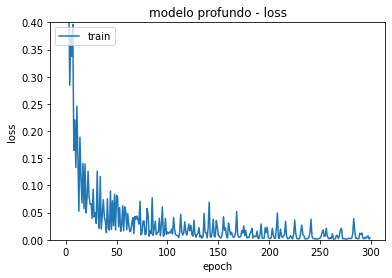

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='relu')

history = model.fit(X_train_scaled, y_train, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.ylim(0,0.4)
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_train, pred_train)}')

pred = model.predict(X_test_scaled, verbose=0)
print(f'MSE test: {mean_squared_error(y_test, pred)}')

MSE train: 0.0017606590505283416
MSE test: 0.004637501409039103


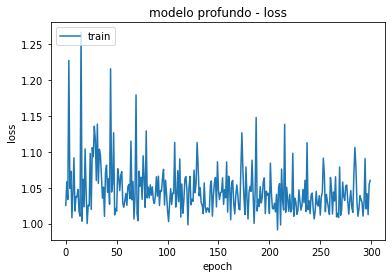

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='sigmoid')

history = model.fit(X_train_scaled, y_train, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_train, pred_train)}')

pred = model.predict(X_test_scaled, verbose=0)
print(f'MSE test: {mean_squared_error(y_test, pred)}')

MSE train: 1.0539765303176876
MSE test: 1.0839532979087574


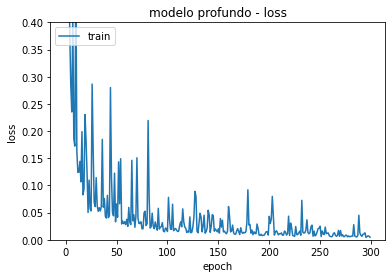

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='tanh')

history = model.fit(X_train_scaled, y_train, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.ylim(0,0.4)
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_train, pred_train)}')

pred = model.predict(X_test_scaled, verbose=0)
print(f'MSE test: {mean_squared_error(y_test, pred)}')

MSE train: 0.008818782820971547
MSE test: 0.010821785271201685


Para la siguiente sección se toma como referencia una MSE de prueba para cada modelo y se compara la variación porcentual con el obtenido por el mismo modelo al añadir el ruido a los datos. Dado que la red con sigmoid tiene un desempeño considerablemente peor que las otras dos redes, se ignora para análisis posteriores con este dataset.

In [0]:
def varPorc(ref, actual):
  return ((actual-ref)/ref)*100

#### Entrenamiento con ruido

En esta sección se prueba la arquitectura anterior con  funciones de activación distintas. Además, se prueba el efecto de la magnitud del ruido variando las desviaciones estándar. A su vez, se ve el efecto que tiene distintas cantidades de etiquetas “corruptas”.

En el caso que la variacion de la MSE del modelo sera superior al 5% se considera que la red no aprende la tarea correcta.

##### 1 desviación estandar

In [0]:
def comparation(X, X_test_scaled, Y, y_test, activation, std, ref , kernel='he_uniform'):
   
    model = Modelo(X.shape[1], kernel=kernel, activation=activation)
    for porcentage in [0.01, 0.05, 0.1, 0.2]:
        y_noise = noise(Y, porcentage, std)
        history = model.fit(X, y_noise, epochs=300, verbose=0)

        pred = model.predict(X_test_scaled, verbose=0)
        var = mean_squared_error(y_test, pred)
        print(f'MSE test con porcentaje corrupto {porcentage} y func. de activacion {activation}:\n{var}')
        print(f'Variacion {varPorc(ref,var)}')
    print('---------------------')

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',1,0.004637501409039103)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.017144694146819073
Variacion 269.69679649911905
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.025768475365547137
Variacion 455.65428649403685
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.021137939852372434
Variacion 355.80449444547435
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.1213918591487842
Variacion 2517.6134181258776
---------------------


En ninguno de los casos se concluye que la red aprende la tarea. Además se ve que el aumentar el porcentaje de datos corruptos tiende a empeorar el rendimiento de la red.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',1,1.0839532979087574)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.9022699723144153
Variacion -16.761176514233494
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.8930686064066495
Variacion -17.61004757957531
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.8828206938631408
Variacion -18.555467697146774
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.8712514968473242
Variacion -19.62278277779986
---------------------


In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'tanh',1,0.010821785271201685)

MSE test con porcentaje corrupto 0.01 y func. de activacion tanh:
0.007898664117747384
Variacion -27.01145033096474
MSE test con porcentaje corrupto 0.05 y func. de activacion tanh:
0.04115688576333623
Variacion 280.3151211368107
MSE test con porcentaje corrupto 0.1 y func. de activacion tanh:
0.020407743122688015
Variacion 88.5801890469582
MSE test con porcentaje corrupto 0.2 y func. de activacion tanh:
0.032517943573580156
Variacion 200.4859434802781
---------------------


Nuevamente se ve que no aprende la tarea y no se ve una clara tendencia al aumentar los datos corruptos.

##### 2 desviación estandar

Se repite el proceso anterior, pero con 2 desviaciones estandar.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',2,0.004637501409039103)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.009022721686500694
Variacion 94.55997725228109
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.11228777264722205
Variacion 2321.2989440468596
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.07901249527070227
Variacion 1603.772965258759
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.2600303113434041
Variacion 5507.120912924589
---------------------


La red no aprende la tarea y se ve una tendencia a emperorar el desempeño al aumentar los datos corruptos.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',2,1.0839532979087574)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
1.1268525507869438
Variacion 3.9576661615358164
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
1.0954482290042424
Variacion 1.0604636858121026
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.9906782707270803
Variacion -8.605078038106456
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.8717871276802802
Variacion -19.573368210402034
---------------------


In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'tanh',2,0.010821785271201685)

MSE test con porcentaje corrupto 0.01 y func. de activacion tanh:
0.021445372240210675
Variacion 98.16852490392571
MSE test con porcentaje corrupto 0.05 y func. de activacion tanh:
0.13616169942521736
Variacion 1158.2184548381597
MSE test con porcentaje corrupto 0.1 y func. de activacion tanh:
0.5190225398700997
Variacion 4696.089802773049
MSE test con porcentaje corrupto 0.2 y func. de activacion tanh:
0.2711173526814065
Variacion 2405.292295929106
---------------------


Se vuelve a ver que la red no aprende la tarea, sin embargo en esta oportunidad se aprecia una tendia a empeorar el rendimiento al tener más datos corruptos.

##### 3 desviación estandar

Finalmante para 3 desviaciones estandar.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',3,0.004637501409039103)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.01534113138865403
Variacion 230.80596716913414
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.10860828712285163
Variacion 2241.9569622374606
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.24189932313426102
Variacion 5116.1563263952285
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.7561373790725585
Variacion 16204.844190424328
---------------------


La red no aprende la tarea y se ve una clara tendencia a empeorar los resultados al aumentar los datos corruptos.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',3,1.0839532979087574)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.882092126132638
Variacion -18.622681638181724
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.9898021425580872
Variacion -8.685905152215835
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.8814694489219048
Variacion -18.680126660207534
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.9909917703158277
Variacion -8.576156165794032
---------------------


In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'tanh',3,0.010821785271201685)

MSE test con porcentaje corrupto 0.01 y func. de activacion tanh:
0.030274476934558144
Variacion 179.75492190852142
MSE test con porcentaje corrupto 0.05 y func. de activacion tanh:
0.05448375484395094
Variacion 403.463647434772
MSE test con porcentaje corrupto 0.1 y func. de activacion tanh:
0.10922699930085225
Variacion 909.3251396469757
MSE test con porcentaje corrupto 0.2 y func. de activacion tanh:
0.4044415865227926
Variacion 3637.2908109632276
---------------------


Una vez más se ve que la red no aprende la tarea y se vuelve a ver el patrón que empeora la red al aumentar los datos corruptos.

#### Conclusion

A grandes razgos para estos 3 escenarios se ve como empeora la red entre más cantidad de datos corruptos hayan, independiente de la función de acticación. Con respecto a la magnitud del ruido se obtienen resultados variados y es difícil establecer una tendencia.

En ningún caso se vio una variación menor al 5%, por lo que se concluye que la red no aprende la tarea si hay al menos un 1% de datos corruptos.

#### Entrenamiento Y aleatorio

En esta segunda parte del experimento con este dataset se ve como se comporta la loss una vez que se hace un shuffle a los valores del target.

Para concluir si la red aprende o no la tarea se analisa la loss al entrenar.

MSE train: 0.25923888914837967


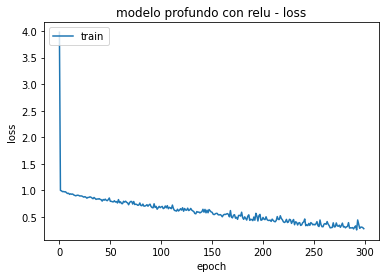

In [0]:
y_noise = shuffle(y_train)
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='relu')
history = model.fit(X_train_scaled, y_noise, epochs=300, verbose=0)

pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con relu - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Se ve un comportamiento estable y una tendencia a disminuir, lo cual sugiere que la red aprendio la tarea.

MSE train: 1.0595304763339


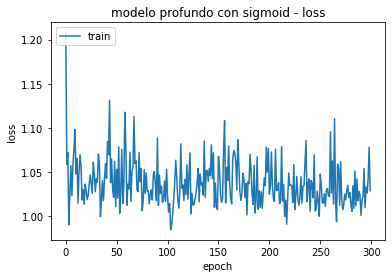

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='sigmoid')
history = model.fit(X_train_scaled, y_noise, epochs=300, verbose=0, validation_data=())

pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con sigmoid - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se ve un comportamiento errático y no hay una tendencia a disminuir la loss, por lo que se conluye que no logró aprender el patrón aleatorio.

MSE train: 0.4561329546976196


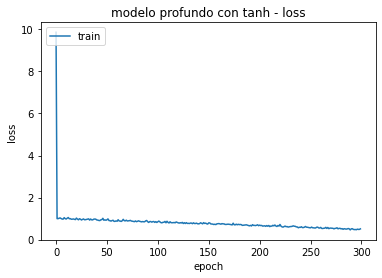

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='tanh')
history = model.fit(X_train_scaled, y_noise, epochs=300, verbose=0, validation_data=())

pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con tanh - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se un comportamiento análogo a lo que se observa con la funcion relu.

#### Conclusion

En dos de los tres escenarios se ve un comportamiento estable y una tendencia a disminuir, lo cual sugiere que al red tiene la capacidad de aprender el target aleatorio.

### Dataset: [Predicción de precios de autos](https://www.kaggle.com/lepchenkov/usedcarscatalog)

Se repite la metodología anterior, pero con otro dataset.

#### Procesamiento de datos

In [0]:
urlCars = 'https://raw.githubusercontent.com/godinezseba/Tarea-1-RedesNeuronales/master/Datasets/cars.csv'
dsCars = pd.read_csv(urlCars)
#dsCars.pop('model_name')
#dsCars = dsCars[['year_produced','odometer_value','engine_capacity','price_usd','duration_listed','transmission' , 'color'	]]
dsCars = pd.get_dummies(dsCars)
dsCars = dsCars.iloc[:1000]
dsCars_train,dsCars_test= train_test_split(dsCars, test_size=0.25, random_state=0)



dsCars.head()


#y = dsCars.pop('price_usd').values




,odometer_value,year_produced,engine_has_gas,engine_capacity,has_warranty,price_usd,is_exchangeable,number_of_photos,up_counter,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,manufacturer_name_Acura,manufacturer_name_Alfa Romeo,manufacturer_name_Audi,manufacturer_name_BMW,manufacturer_name_Buick,manufacturer_name_Cadillac,manufacturer_name_Chery,manufacturer_name_Chevrolet,manufacturer_name_Chrysler,manufacturer_name_Citroen,manufacturer_name_Dacia,manufacturer_name_Daewoo,manufacturer_name_Dodge,manufacturer_name_Fiat,manufacturer_name_Ford,manufacturer_name_Geely,manufacturer_name_Great Wall,manufacturer_name_Honda,manufacturer_name_Hyundai,manufacturer_name_Infiniti,...,color_orange,color_other,color_red,color_silver,color_violet,color_white,color_yellow,engine_fuel_diesel,engine_fuel_electric,engine_fuel_gas,engine_fuel_gasoline,engine_fuel_hybrid-diesel,engine_fuel_hybrid-petrol,engine_type_diesel,engine_type_electric,engine_type_gasoline,body_type_cabriolet,body_type_coupe,body_type_hatchback,body_type_liftback,body_type_limousine,body_type_minibus,body_type_minivan,body_type_pickup,body_type_sedan,body_type_suv,body_type_universal,body_type_van,state_emergency,state_new,state_owned,drivetrain_all,drivetrain_front,drivetrain_rear,location_region_Брестская обл.,location_region_Витебская обл.,location_region_Гомельская обл.,location_region_Гродненская обл.,location_region_Минская обл.,location_region_Могилевская обл.
0,190000,2010,False,2.5,False,10900.00,False,9,13,False,True,True,True,False,True,False,True,True,True,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
1,290000,2002,False,3.0,False,5000.00,True,12,54,False,True,False,False,True,True,False,False,False,True,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
2,402000,2001,False,2.5,False,2800.00,True,4,72,False,True,False,False,False,False,False,False,True,True,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0
3,10000,1999,False,3.0,False,9999.00,True,9,42,True,False,False,False,False,False,False,False,False,False,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
4,280000,2001,False,2.5,False,2134.11,True,14,7,False,True,False,True,True,False,False,False,False,True,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0


In [0]:
scaler = StandardScaler().fit(dsCars_train)

X_train_scaled = pd.DataFrame(scaler.transform(dsCars_train),columns=dsCars_train.columns)
y_train = X_train_scaled.pop('price_usd').values.reshape(-1,1)

X_test_scaled =  pd.DataFrame(scaler.transform(dsCars_test),columns=dsCars_test.columns)
y_test = X_test_scaled.pop('price_usd').values.reshape(-1,1)


In [0]:
X_train_scaled.head()

,odometer_value,year_produced,engine_has_gas,engine_capacity,has_warranty,is_exchangeable,number_of_photos,up_counter,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,manufacturer_name_Acura,manufacturer_name_Alfa Romeo,manufacturer_name_Audi,manufacturer_name_BMW,manufacturer_name_Buick,manufacturer_name_Cadillac,manufacturer_name_Chery,manufacturer_name_Chevrolet,manufacturer_name_Chrysler,manufacturer_name_Citroen,manufacturer_name_Dacia,manufacturer_name_Daewoo,manufacturer_name_Dodge,manufacturer_name_Fiat,manufacturer_name_Ford,manufacturer_name_Geely,manufacturer_name_Great Wall,manufacturer_name_Honda,manufacturer_name_Hyundai,manufacturer_name_Infiniti,manufacturer_name_Iveco,...,color_orange,color_other,color_red,color_silver,color_violet,color_white,color_yellow,engine_fuel_diesel,engine_fuel_electric,engine_fuel_gas,engine_fuel_gasoline,engine_fuel_hybrid-diesel,engine_fuel_hybrid-petrol,engine_type_diesel,engine_type_electric,engine_type_gasoline,body_type_cabriolet,body_type_coupe,body_type_hatchback,body_type_liftback,body_type_limousine,body_type_minibus,body_type_minivan,body_type_pickup,body_type_sedan,body_type_suv,body_type_universal,body_type_van,state_emergency,state_new,state_owned,drivetrain_all,drivetrain_front,drivetrain_rear,location_region_Брестская обл.,location_region_Витебская обл.,location_region_Гомельская обл.,location_region_Гродненская обл.,location_region_Минская обл.,location_region_Могилевская обл.
0,-1.043481,0.377104,-0.31063,-1.125858,-0.081923,1.306745,-0.319680,-0.351495,-0.453638,0.665062,2.246862,1.704773,-0.514544,1.248890,-0.394492,1.557131,1.245400,0.802955,-0.048966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.646351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.127515,-0.335797,-0.289508,2.124784,-0.089803,-0.297547,-0.081923,-0.255619,0.0,-0.31063,0.418985,0.0,0.0,-0.255619,0.0,0.255619,0.0,-0.110208,2.914390,-0.089803,0.0,-0.116248,-0.401236,-0.137919,-0.600967,-0.529021,-0.510396,-0.116248,-0.116248,-0.081923,0.142857,-0.855629,0.893622,-0.147643,-0.240474,-0.261488,-0.286794,-0.243561,0.671325,-0.252646
1,-0.552816,0.641800,-0.31063,1.807519,-0.081923,-0.765261,-0.775498,-0.315978,-0.453638,0.665062,-0.445065,-0.586588,-0.514544,-0.800711,-0.394492,1.557131,1.245400,0.802955,-0.311041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.547147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.127515,-0.335797,-0.289508,-0.470636,-0.089803,3.360816,-0.081923,-0.255619,0.0,-0.31063,0.418985,0.0,0.0,-0.255619,0.0,0.255619,0.0,-0.110208,-0.343125,-0.089803,0.0,-0.116248,2.492296,-0.137919,-0.600967,-0.529021,-0.510396,-0.116248,-0.116248,-0.081923,0.142857,-0.855629,0.893622,-0.147643,-0.240474,-0.261488,-0.286794,-0.243561,0.671325,-0.252646
2,0.886408,-0.946377,-0.31063,0.270988,-0.081923,1.306745,0.288077,-0.333736,2.204399,-1.503619,-0.445065,-0.586588,-0.514544,-0.800711,-0.394492,-0.642207,-0.802955,-1.245400,-0.581570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.646351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.127515,-0.335797,-0.289508,2.124784,-0.089803,-0.297547,-0.081923,-0.255619,0.0,-0.31063,0.418985,0.0,0.0,-0.255619,0.0,0.255619,0.0,-0.110208,-0.343125,-0.089803,0.0,-0.116248,-0.401236,-0.137919,-0.600967,1.890283,-0.510396,-0.116248,-0.116248,-0.081923,0.142857,1.168730,-1.119041,-0.147643,-0.240474,-0.261488,-0.286794,-0.243561,0.671325,-0.252646
3,0.299768,-0.814029,-0.31063,-0.427435,-0.081923,-0.765261,-0.015802,-0.333736,-0.453638,0.665062,-0.445065,-0.586588,1.943469,-0.800711,-0.394492,-0.642207,-0.802955,0.802955,-0.657656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.646351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.127515,-0.335797,-0.289508,2.124784,-0.089803,-0.297547,-0.081923,-0.255619,0.0,-0.31063,0.418985,0.0,0.0,-0.255619,0.0,0.255619,0.0,-0.110208,-0.343125,-0.089803,0.0,-0.116248,-0.401236,-0.137919,1.663984,-0.529021,-0.510396,-0.116248,-0.116248,-0.081923,0.142857,-0.855629,0.893622,-0

#### Entrenamiento sin alteraciones

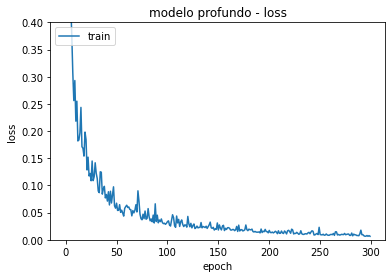

In [0]:
model = Modelo(X_train_scaled_cars.shape[1], kernel='he_uniform', activation='relu')

history = model.fit(X_train_scaled_cars, y_train_cars, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.ylim(0,0.4)
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train_cars = model.predict(X_train_scaled_cars, verbose=0)
print(f'MSE train: {mean_squared_error(y_train_cars, pred_train_cars)}')

pred_cars = model.predict(X_test_scaled_cars, verbose=0)
print(f'MSE test: {mean_squared_error(y_test_cars, pred_cars)}')

MSE train: 0.006508854378845065
MSE test: 0.0788472943926568


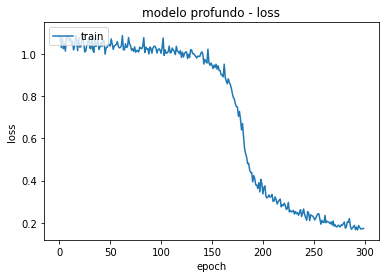

In [0]:
model = Modelo(X_train_scaled_cars.shape[1], kernel='he_uniform', activation='sigmoid')

history = model.fit(X_train_scaled_cars, y_train_cars, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train_cars = model.predict(X_train_scaled_cars, verbose=0)
print(f'MSE train: {mean_squared_error(y_train_cars, pred_train_cars)}')

pred_cars = model.predict(X_test_scaled_cars, verbose=0)
print(f'MSE test: {mean_squared_error(y_test_cars, pred_cars)}')

MSE train: 0.23333931184378964
MSE test: 0.21373315687936587


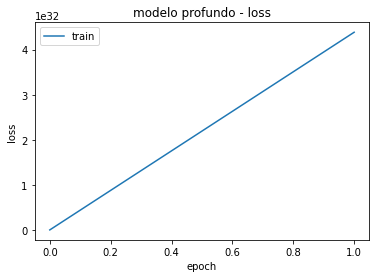

In [0]:
model = Modelo(X_train_scaled_cars.shape[1], kernel='he_uniform', activation='tanh')

history = model.fit(X_train_scaled_cars, y_train_cars, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Dado que la red con tanh tiene una loss creciente se excluye del análisis.

#### Entrenamiento con ruido

##### 1 desviación estandar

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',1,0.0788472943926568)


MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.12084020581467829
Variacion 53.25853188176407
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.15273614681239486
Variacion 93.71133529550696
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.23254750338130742
Variacion 194.93403061267884
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.3324640238013901
Variacion 321.65558927834707
---------------------


En ningún caso la red aprende la tarea y se ve una tendencia a dismunir el desempeño al aumentar los datos corruptos.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',1,0.21373315687936587)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.15936775332311515
Variacion -25.436111247322916
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.09438903899064802
Variacion -55.83790537285584
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.21533171501447723
Variacion 0.747922389979771
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.08803094462299954
Variacion -58.812686852940885
---------------------


Se observa un escenario en donde la red aprende la tarea, sin embargo dado que los otros resultados son irregulares, esto es, la red aprende mejor la tarea con datos corruptos se ignora esta observación para una conclusión posterior.

##### 2 desviación estandar

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',2,0.0788472943926568)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.0814485021520054
Variacion 3.29904504572431
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.2582091436405151
Variacion 227.4800303922193
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.4323919751745312
Variacion 448.39164552842374
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.6534951453913279
Variacion 728.8111220873917
---------------------


Se observa un escenario en donde la red aprende la tarea, además de la tendencia de aumentar el MSE al aumentar los datos corruptos.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',2,0.21373315687936587)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.14672855863253553
Variacion -31.349650763193804
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.1887389560977166
Variacion -11.694114823633265
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.16535809251673975
Variacion -22.63339252969988
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.2622025357831103
Variacion 22.677519768774705
---------------------


Al igual que en el caso anterior se ignoran estos resultados.

##### 3 desviación estandar

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',3,0.0788472943926568)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.18657157728348658
Variacion 136.623943434719
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.4103879736466688
Variacion 420.4845350849338
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.6119743779297164
Variacion 676.151398273865
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
1.256363263883535
Variacion 1493.4132852129198
---------------------


En ningun caso la red aprende la tarea y se ve la tendencia mencionada anteriormente.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',3,0.21373315687936587)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.178094445800446
Variacion -16.674395119253713
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.214579557703737
Variacion 0.3960081986010459
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.22268661109227245
Variacion 4.189080601078681
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.4821536986590851
Variacion 125.58675766494186
---------------------


Una vez más se ignoran estos resultados, puesto que se encuentra un valor negativo.

#### Conclusion

En solamente en un escenario con 2 desviaciones estandar se ve que la red aprendio la tarea, sin embargo esto no es sufiente para concluir que una red cualquiera tenga este comportamiento. En vista de esto se concluye que la red si tiene al menos un 1% de datos corruptos no aprende la tarea.

#### Entrenamiento con Y aleatorio

MSE train: 0.008439811607591817


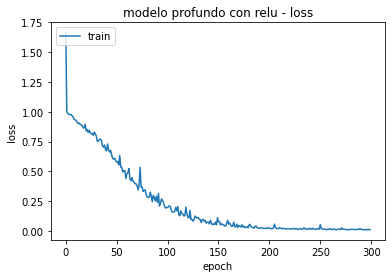

In [0]:
y_noise = shuffle(y_train_cars)
model = Modelo(X_train_scaled_cars.shape[1], kernel='he_uniform', activation='relu')
history = model.fit(X_train_scaled_cars, y_noise, epochs=300, verbose=0)

pred_train_cars = model.predict(X_train_scaled_cars, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train_cars)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con relu - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se ve un comportamiento estable y decreciente de la loss.

MSE train: 1.0019536787311967


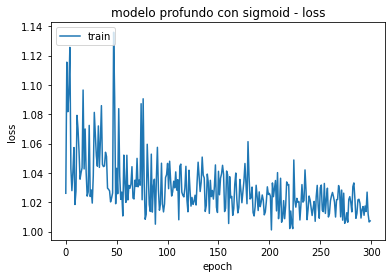

In [0]:
y_noise = shuffle(y_train_cars)
model = Modelo(X_train_scaled_cars.shape[1], kernel='he_uniform', activation='sigmoid')
history = model.fit(X_train_scaled_cars, y_noise, epochs=300, verbose=0)

pred_train_cars = model.predict(X_train_scaled_cars, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train_cars)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con sigmoid - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se ve un comportamiento errático de la loss.

#### Conclusion

Dado que no se pudo utilizar tanh, por su mal comportamiento en el modelo solo se comparo relu y sigmoid. En base a esto en uno de los casos se ve que la red aprende el target aleatorio.

### Dataset: [Función de piramide](https://academo.org/demos/3d-surface-plotter/?expression=1-abs(x%2By)-abs(y-x)&xRange=-50%2C+50&yRange=-50%2C+50&resolution=24)

#### Procesamiento de datos

In [0]:
import csv
dominio_x = 10
dominio_y = 10
with open('funcion.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["X", "Y", "Z"])
  for i in range(dominio_x+1):
    for j in range(-dominio_y,dominio_y+1):
      z = 1-abs(i+j)-abs(j-i)
      writer.writerow([i, j, z])
      #z = 1-abs(i-j)-abs(-j-i)
      #writer.writerow([i, -j, z])

dsfuncion = pd.read_csv('funcion.csv')


from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df1 = pd.read_csv('funcion.csv', parse_dates=True)

dominio_x = 10
dominio_y = 10
with open('funcion1.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["X", "Y", "Z"])
  for i in range(-dominio_x,0):
    for j in range(-dominio_y,dominio_y+1):
      z = 1-abs(i+j)-abs(j-i)
      writer.writerow([i, j, z])
      #z = 1-abs(i-j)-abs(-j-i)
      #writer.writerow([i, -j, z])

df2= pd.read_csv('funcion1.csv')

frames = [df1,df2]

df3 = pd.concat(frames)


df_train,df_test= train_test_split(df3, test_size=0.25, random_state=0)

df3.shape

(441, 3)

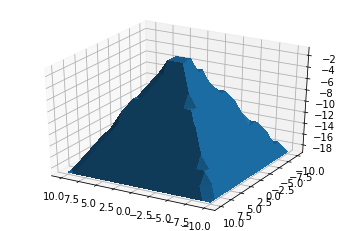

In [0]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(df_train["X"], df_train["Y"], df_train["Z"], linewidth=0, antialiased=False)
#threedee.scatter(df["X"], df['Y'], df['Z'])
#threedee.set_xlabel('X')
#threedee.set_ylabel('Y')
#threedee.set_zlabel('Z')
ax.view_init(azim=120)
plt.show()

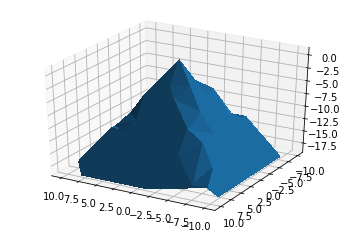

In [0]:


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(df_test["X"], df_test["Y"], df_test["Z"], linewidth=0, antialiased=False)
#threedee.scatter(df["X"], df['Y'], df['Z'])
#threedee.set_xlabel('X')
#threedee.set_ylabel('Y')
#threedee.set_zlabel('Z')
ax.view_init(azim=120)
plt.show()


In [0]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = X_train_scaled.pop('Z').values.reshape(-1,1)

X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = X_test_scaled.pop('Z').values.reshape(-1,1)

In [0]:
X_train_scaled.head()

,X,Y
0,0.011774,1.613708
1,-0.797712,1.128566
2,-1.283404,-0.326858
3,0.011774,0.643425
4,-1.121507,-0.650285


#### Entrenamiento sin alteraciones

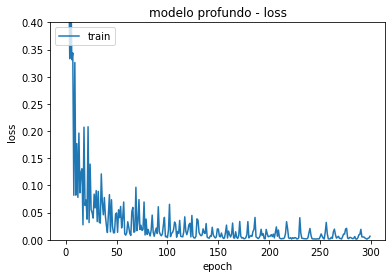

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='relu')

history = model.fit(X_train_scaled, y_train, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.ylim(0,0.4)
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_train, pred_train)}')

pred = model.predict(X_test_scaled, verbose=0)
print(f'MSE test: {mean_squared_error(y_test, pred)}')

MSE train: 0.0011290853299344996
MSE test: 0.0048022141511878825


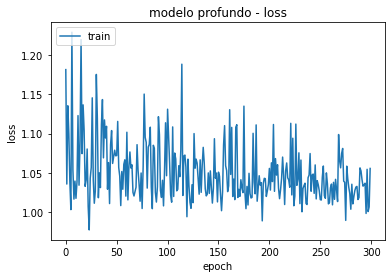

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='sigmoid')

history = model.fit(X_train_scaled, y_train, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_train, pred_train)}')

pred = model.predict(X_test_scaled, verbose=0)
print(f'MSE test: {mean_squared_error(y_test, pred)}')

MSE train: 1.000464573235131
MSE test: 0.9042756796927652


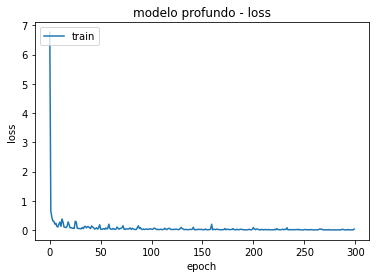

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='tanh')

history = model.fit(X_train_scaled, y_train, epochs=300, verbose=0)

plt.plot(history.history['loss'])
plt.title('modelo profundo - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_train, pred_train)}')

pred = model.predict(X_test_scaled, verbose=0)
print(f'MSE test: {mean_squared_error(y_test, pred)}')

MSE train: 0.026135700727961567
MSE test: 0.028866798783569472


#### Entrenamiento con ruido

##### 1 desviación estandar

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',1,0.0048022141511878825)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.00799000682440055
Variacion 66.38172669630177
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.028750152748399344
Variacion 498.6853531154512
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.015489784651322487
Variacion 222.55505822227676
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.09590427516916329
Variacion 1897.0845145554429
---------------------


En ningún caso la red aprende la tarea y se ve la tendencia encontrada en los otros dataset.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',1,0.9042756796927652)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.8707907687048866
Variacion -3.7029538380657776
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.9697667003155732
Variacion 7.242373326357629
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.8817827527161134
Variacion -2.4873970938037377
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.9505660133114436
Variacion 5.119051043638143
---------------------


Se ignoran los resultas al obtener variaciones negativas.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'tanh',1,0.028866798783569472)

MSE test con porcentaje corrupto 0.01 y func. de activacion tanh:
0.01089627093037018
Variacion -62.253275771707095
MSE test con porcentaje corrupto 0.05 y func. de activacion tanh:
0.014276473349265878
Variacion -50.54362121583145
MSE test con porcentaje corrupto 0.1 y func. de activacion tanh:
0.04103565447619666
Variacion 42.15519629961017
MSE test con porcentaje corrupto 0.2 y func. de activacion tanh:
0.07342906204053297
Variacion 154.37202992639294
---------------------


Una vez más se descartan estos resultados.

##### 2 desviación estandar

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',2,0.0048022141511878825)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.0778942150388167
Variacion 1522.0479259457572
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.08034547244088851
Variacion 1573.0922426900545
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.04206556855523591
Variacion 775.9619465289884
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.20595934053703843
Variacion 4188.841231415971
---------------------


Nuevamente en ningún caso la red aprende la tarea.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',2,0.9042756796927652)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
0.8935480270403047
Variacion -1.186325463945394
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.8911696681002156
Variacion -1.4493380599379295
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.8863411407514845
Variacion -1.9833043555228778
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
1.0331399364492866
Variacion 14.250549876593386
---------------------


Se descartan estos resultados.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'tanh',2,0.028866798783569472)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
1.105280629922328
Variacion 22.228282231128418
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.9643241375712027
Variacion 6.640503468902252
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.8774449411189169
Variacion -2.967097222272336
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.8978038622761774
Variacion -0.7156907524911781
---------------------


Se descartan estos resultados.

##### 3 desviación estandar

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'relu',3,0.0048022141511878825)

MSE test con porcentaje corrupto 0.01 y func. de activacion relu:
0.054338153801746766
Variacion 1031.5229202826283
MSE test con porcentaje corrupto 0.05 y func. de activacion relu:
0.08572911403514634
Variacion 1685.1997294610503
MSE test con porcentaje corrupto 0.1 y func. de activacion relu:
0.16158921491897044
Variacion 3264.8898160653557
MSE test con porcentaje corrupto 0.2 y func. de activacion relu:
0.779364312262556
Variacion 16129.270243389112
---------------------


En ningún caso la red aprende la tarea y se ve la tendencia mencionada anteriormente.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'sigmoid',3,0.9042756796927652)

MSE test con porcentaje corrupto 0.01 y func. de activacion sigmoid:
1.0250331300521245
Variacion 13.35405264911996
MSE test con porcentaje corrupto 0.05 y func. de activacion sigmoid:
0.8842555645163492
Variacion -2.2139393578756854
MSE test con porcentaje corrupto 0.1 y func. de activacion sigmoid:
0.9137724828571396
Variacion 1.0502110559471216
MSE test con porcentaje corrupto 0.2 y func. de activacion sigmoid:
0.9656663616408391
Variacion 6.788934318009283
---------------------


Se descartan los resultados.

In [0]:
comparation(X_train_scaled, X_test_scaled, y_train, y_test,'tanh',3,0.028866798783569472)

MSE test con porcentaje corrupto 0.01 y func. de activacion tanh:
0.0458326898552134
Variacion 58.773025713196326
MSE test con porcentaje corrupto 0.05 y func. de activacion tanh:
0.039178705488067185
Variacion 35.7223770526543
MSE test con porcentaje corrupto 0.1 y func. de activacion tanh:
0.1913386577524526
Variacion 562.832963180384
MSE test con porcentaje corrupto 0.2 y func. de activacion tanh:
0.668085305395059
Variacion 2214.372682624312
---------------------


Se descartan los resultados.

#### Conclusion

En ningún escenario la red aprende la tarea, por lo que se concluye que con al menos un 1% de datos corruptos la red no aprende la tarea de forma correcta.

#### Entrenamiento con Y aleatorio

MSE train: 0.8770804131570963


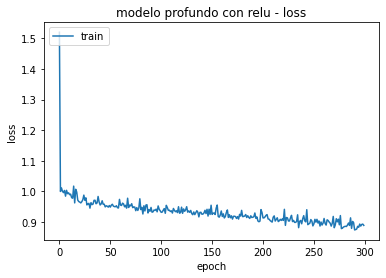

In [0]:
y_noise = shuffle(y_train)
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='relu')
history = model.fit(X_train_scaled, y_noise, epochs=300, verbose=0)

pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con relu - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se ve un comportamiento estable y decreciente.

MSE train: 1.0713721084422752


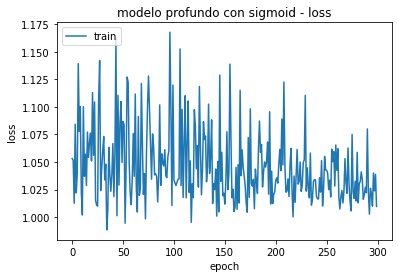

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='sigmoid')
history = model.fit(X_train_scaled, y_noise, epochs=300, verbose=0, validation_data=())

pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con sigmoid - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se ve un comportamiento errático.

MSE train: 0.9859411503554569


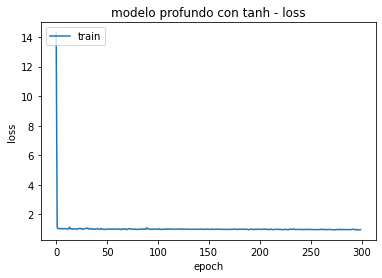

In [0]:
model = Modelo(X_train_scaled.shape[1], kernel='he_uniform', activation='tanh')
history = model.fit(X_train_scaled, y_noise, epochs=300, verbose=0, validation_data=())

pred_train = model.predict(X_train_scaled, verbose=0)
print(f'MSE train: {mean_squared_error(y_noise, pred_train)}')

plt.plot(history.history['loss'])
plt.title('modelo profundo con tanh - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se ve un comportamiento estable y decreciente.

#### Conclusion

En 2 de los 3 escenarios se ve un comporamiento estable y decreciente de la loss, lo cual sugiere que sí aprende el target aleatorio.

### Conclusión de la experimentación

En esta seccion se da una respuesta a cada unas de las preguntas que se planteo al inicio.

Con respecto a que la red puede o no aprender un target aleatorio, los resultados experimentales sugieren que sí, para problemas de regresión. En cada uno dataset que se experimento se pudo evidenciar al menos un caso en que el comportamiento de la loss fue estable y decreciente. Sin embargo, cabe mencionar que no cualquier red puede aprender un target aleatorio, como se vio al utilizar una función de activación sigmoidal fallaba en captar esta naturaleza aleatoria.

Con respecto a que la red puede aprender la red aprende la tarea correcta si el porcetaje de etiquetas corruptas es pequeño con respecto al criterio que se utilizó se encontró que no aprende la tarea correcta, al menos para problemas de regresion. Sin embargo, hay diversos factores que se pueden haber influenciado este resultado. 

El primero de estos es el criterio que se utilizó para juzgar si la red aprende o no, en particular se utilizó variacion porcentual, pero puede que este no haya sido la mejor opción. Por ejemplo, la variación porcental del MSE entre 0.004 y 0.006 es del 50% a pesar que son valores muy cercanos entre si.

El segundo de los factores que afectó la conclusión obtenida fue que se utilizó la misma arquitectura para 3 problemas de regresión distintos. Se decidio por hacer una comparación "justa" al comparar la misma red en 3 dataset diferentes, no obstante no se tuneo apropiadamente cada red para adptarse al problema.

Otro factor que pudo influir  en el resultado es quizas es ruido mismo que se fabricó. Se utilizó 1, 2 y 3 desviaciones estandar escaladas por un factor de una distribución normal, no obstante puede que haya sido mejor experimentar con 0.25, 0.5 y 1 desviaciones estandar.

Finalmente, no se considero el efecto que tiene el numero de datos disponibles para el entrenamiento. Se trabajo con un bajo volumen de datos, esto es, menos de 1000. Se pudo haber dado el caso que para un mayor número de datos de entrenamiento la red pudo haber sido más robusta a los datos contaminados.

Para terminar se comenta sobre otras observaciones adicional que no estan explicitamente mencionadas en la pregunta del inicio.

Se decidio usar una arquitectura fija y se cambio la función de activación para generar diversidad versiones de esta red, no obstante esto no enriquecio la experimentación, dado que en muchos casos se tuvo que descartar los resultados por el mal comportamiento de la red.

No se observo una clara tendencia con respecto a la magnitud del ruido como a mayor ruido mayor MSE, es mas el único caso que se vio que la red aprende con etiquetas corruptas tenia 2 desviaciones estandar en vez de 1.

<a id="segundo"></a>
## 2. Challenge Kaggle

[Descripción](https://www.kaggle.com/c/taller1ann-usm/overview/description)